In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format
sns.set_theme(color_codes=True)

In [2]:
def log(f):
    def wrapper(df, *args, **kwargs):
        start = dt.datetime.now()
        result = f(df, *args, **kwargs)
        stop = dt.datetime.now()
        print(f'{f.__name__}:\n  runtime={stop - start}, end shape={result.shape}')
        return result
    return wrapper

@log
def startPipeline(df):
    return df.copy()

@log
def clean(df):
    df = df[[
        'ConvertedCompYearly',
        # 'EdLevel', # will need to vectorize (worst = 0, best = 1, rest in between)
        'Employment',
        # 'Age1stCode', 
        'YearsCode', 
        'YearsCodePro', 
        # 'OrgSize'
    ]]
    df = df[df["Employment"] == "Employed full-time"]
    df = df.drop("Employment", axis=1)
    df = df.dropna(subset=['ConvertedCompYearly'])
    # do this better. don't drop these. vectorize them.
    # drop rows in 'YearsCode', 'YearsCodePro' that are 'Less than 1 year'
    df = df[df['YearsCode'].str.contains('Less than 1 year')==False]
    df = df[df['YearsCodePro'].str.contains('Less than 1 year')==False]
    df = df[df['YearsCode'].str.contains('More than 50 years')==False]
    df = df[df['YearsCodePro'].str.contains('More than 50 years')==False]

    df[['YearsCode', 'YearsCodePro']] = df[['YearsCode', 'YearsCodePro']].apply(pd.to_numeric)

    df = df.round(2)

    return df

@log 
def removeOutliers(df):
    # df = df[(np.abs(stats.zscore(df['ConvertedCompYearly'])) < .25)]
    df = df[df["ConvertedCompYearly"] <= 300000]
    df = df[df["ConvertedCompYearly"] >= 15000]
    return df

def get_df():
    df_raw = pd.read_csv('./data/stack-overflow-developer-survey-2021/survey_results_public.csv')
    return (df_raw
        .pipe(startPipeline)
        .pipe(clean)
        .pipe(removeOutliers)
)

In [3]:
df = get_df()
df.head()

startPipeline:
  runtime=0:00:00.016768, end shape=(83439, 48)
clean:
  runtime=0:00:00.108852, end shape=(38506, 3)
removeOutliers:
  runtime=0:00:00.002157, end shape=(32440, 3)


,ConvertedCompYearly,YearsCode,YearsCodePro
9,51552.00,7,4
11,46482.00,12,5
12,77290.00,15,6
16,17748.00,6,2
17,46135.00,9,6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32440 entries, 9 to 83438
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ConvertedCompYearly  32440 non-null  float64
 1   YearsCode            32440 non-null  int64  
 2   YearsCodePro         32440 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 1013.8 KB


In [5]:
# df['Country'].value_counts()

In [6]:
df.describe()

,ConvertedCompYearly,YearsCode,YearsCodePro
count,32440.00,32440.00,32440.00
mean,77436.57,15.35,9.71
std,51585.35,9.24,7.62
min,15000.00,1.00,1.00
25%,39324.00,8.00,4.00
50%,64859.00,13.00,7.00
75%,100524.00,20.00,13.00
max,300000.00,50.00,50.00


In [7]:
reg = LinearRegression()
label = 'ConvertedCompYearly'
labels = df[label]
train = df.drop([label], axis=1)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, random_state=1776)

In [9]:
reg.fit(x_train, y_train)

LinearRegression()

In [10]:
def performance(x, y, name):
    y_predict = reg.predict(x)
    rmse = (np.sqrt(mean_squared_error(y, y_predict)))
    r2 = r2_score(y, y_predict)

    print(name)
    print(f'  rmse={rmse}, r2={r2}')


performance(x_train, y_train, 'train')
performance(x_test, y_test, 'test')

train
  rmse=48735.876129219636, r2=0.10863140583697295
test
  rmse=48580.46985100156, r2=0.1080686346914469


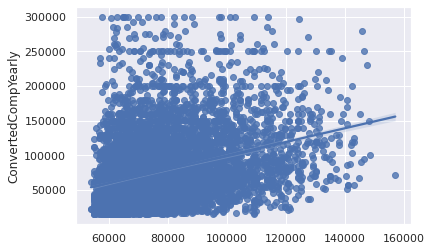

In [11]:
predicted = reg.predict(x_test)
expected = y_test
ax = sns.regplot(x=predicted, y=expected)

In [12]:
import tensorflow as tf
from tensorflow import keras

2022-04-11 16:57:18.286561: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-11 16:57:18.286618: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
df = get_df()
print(df.shape)
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

startPipeline:
  runtime=0:00:00.017240, end shape=(83439, 48)
clean:
  runtime=0:00:00.120226, end shape=(38506, 3)
removeOutliers:
  runtime=0:00:00.002469, end shape=(32440, 3)
(32440, 3)


In [14]:
train_dataset.tail()

,ConvertedCompYearly,YearsCode,YearsCodePro
29016,56211.00,9,3
33517,34596.00,8,1
65738,32906.00,8,2
16214,83500.00,10,4
11795,59454.00,12,8


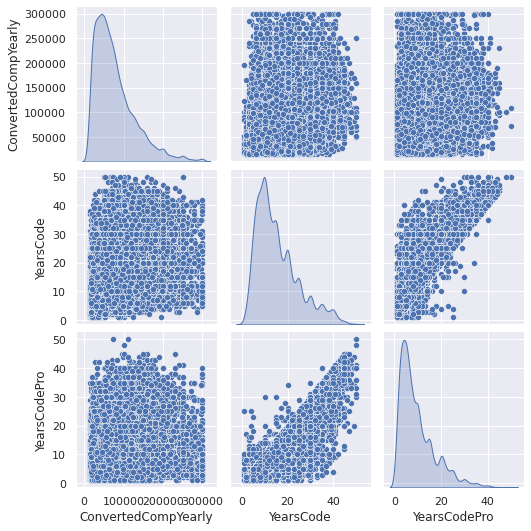

In [15]:
sns.pairplot(train_dataset, diag_kind="kde")

In [16]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ConvertedCompYearly,25952.00,77423.59,51734.71,15000.00,39093.00,64794.00,100345.00,300000.00
YearsCode,25952.00,15.35,9.25,1.00,8.00,13.00,20.00,50.00
YearsCodePro,25952.00,9.70,7.62,1.00,4.00,7.00,13.00,50.00


In [17]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('ConvertedCompYearly')
test_labels = test_features.pop('ConvertedCompYearly')

In [18]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
ConvertedCompYearly,77423.59,51734.71
YearsCode,15.35,9.25
YearsCodePro,9.70,7.62


In [19]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

2022-04-07 20:27:36.503054: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-07 20:27:36.503145: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-07 20:27:36.503168: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BC-T480): /proc/driver/nvidia/version does not exist
2022-04-07 20:27:36.504049: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[15.347445  9.700835]]


In [20]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[15  8]]

Normalized: [[-0.04 -0.22]]


In [21]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [22]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,422
Trainable params: 4,417
Non-trainable params: 5
_________________________________________________________________


In [24]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=50)

CPU times: user 2min 21s, sys: 51 s, total: 3min 12s
Wall time: 1min 27s


In [25]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

35152.328125

In [40]:
tf.saved_model.save(dnn_model, './dnn_model')
tf.keras.models.save_model(dnn_model, './dnn_model_keras')

INFO:tensorflow:Assets written to: ./dnn_model/assets
INFO:tensorflow:Assets written to: ./dnn_model_keras/assets


In [41]:
# saved_dnn_model = tf.saved_model.load('./dnn_model')
saved_dnn_model_keras = tf.keras.models.load_model('./dnn_model_keras')

In [42]:
# print(list(saved_dnn_model.signatures.keys()))
# infer = saved_dnn_model.signatures["serving_default"]
# saved_dnn_model.evaluate(test_features, test_labels, verbose=0)
saved_dnn_model_keras.evaluate(test_features, test_labels, verbose=0)


35152.328125

In [45]:
# predict salary for 30 years and 32 years
saved_dnn_model_keras.predict(np.array([30, 32]))

array([[109091.555]], dtype=float32)